In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import keras
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import seaborn as sns
from numpy import array
from numpy import hstack
from sklearn.metrics import mean_squared_error, explained_variance_score
from keras.callbacks import EarlyStopping
from matplotlib import font_manager, rc
from keras.models import Model
from keras import layers
from keras import Input
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
import math

# 일변량 / ts : time_step / lag : 얼마 뒤 예측을 할것인가 / duration : 얼마를 예측할 것인가
def time_step(data, ts, lag, duration):
    dataX = []
    dataY = []
    
    for i in range(len(data)-ts-(lag-1)-(duration-1)):
        dataX.append(data[i:i+ts])
        dataY.append(data[i+ts+lag-1:i+ts+lag-1+duration])
    dataX = np.array(dataX)
    dataY = np.array(dataY)  

    return dataX, dataY

# 다변량
def split_mult_data(data, timestep, lag):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + timestep
        out_end_ix = end_ix + lag
        if out_end_ix > len(data):
            break;
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, 0]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

# 분할 데이터 정규화
def normalization(data_train, data_val, data_test):
    scaler = MinMaxScaler() #StandardScaler
    scaler.fit(data_train)
    n_data_train = scaler.transform(data_train)
    n_data_val = scaler.transform(data_val)
    n_data_test = scaler.transform(data_test)
    return n_data_train, n_data_val, n_data_test

In [3]:
# 코로나 데이터
covid19 = pd.read_csv("covid19.csv",  header=0, squeeze=True)
covid19 = covid19[{'decide_per_day' : '확진자', 'recovered_per_day' : '완치자', 'death_per_day' : '사망자'}]
covid19.columns = ['확진자', '완치자', '사망자']
covid19 = covid19['확진자']
covid19 = covid19.values
covid19

array([   1,    0,    0,    0,    1,    0,    1,    1,    0,    0,    0,
          7,    1,    3,    0,    1,    3,    4,    1,    0,    1,    2,
          1,    0,    0,    0,    0,    1,    1,    1,    0,   73,  100,
        229,  169,  231,  144,  284,  505,  571,  813,  586,  599,  851,
        435,  467,  505,  448,  273,  164,   35,  242,  114,  110,  107,
         76,   74,   84,   93,  152,   87,  147,  162,    0,   76,  100,
        104,   91,  146,  105,   78,  125,  101,   89,   86,   94,   81,
         47,   47,   53,   39,   27,   30,   32,   25,   27,   27,   22,
         22,   18,    8,   13,    9,   11,   14,   10,   10,   10,   14,
          9,    4,    9,    6,   13,    8,    3,    2,    4,   12,   18,
         34,   35,   27,   26,   29,   27,   19,   13,   15,   13,   32,
         12,   20,   23,   25,   16,   19,   40,   79,   58,   39,   27,
         35,   38,   49,   39,   39,   51,   57,   38,   38,   50,   45,
         56,   48,   34,   36,   34,   43,   59,   

In [7]:
data_X, data_Y = time_step(covid19, 7, 1, 1)

# 데이터 분할
NUM_TRAIN = int(data_X.shape[0] * 0.6)
NUM_VAL = int(data_X.shape[0] * 0.8)

train_X = data_X[:NUM_TRAIN]
covid_train_y = data_Y[:NUM_TRAIN]

val_X = data_X[NUM_TRAIN:NUM_VAL]
covid_val_y = data_Y[NUM_TRAIN:NUM_VAL]

test_X = data_X[NUM_VAL:]
covid_test_y =data_Y[NUM_VAL:]

covid_train_x, covid_val_x, covid_test_x = normalization(train_X, val_X, test_X)

In [ ]:
rmse =[]
r2 = []
    
for ts in range(1, 7, 1): 

    data_X, data_Y = time_step(covid19, ts, 1, 1)

    # 데이터 분할
    NUM_TRAIN = int(data_X.shape[0] * 0.6)
    NUM_VAL = int(data_X.shape[0] * 0.8)

    train_X = data_X[:NUM_TRAIN]
    covid_train_y = data_Y[:NUM_TRAIN]

    val_X = data_X[NUM_TRAIN:NUM_VAL]
    covid_val_y = data_Y[NUM_TRAIN:NUM_VAL]

    test_X = data_X[NUM_VAL:]
    covid_test_y =data_Y[NUM_VAL:]

    covid_train_x, covid_val_x, covid_test_x = normalization(train_X, val_X, test_X)

    tf.random.set_seed(555)

    # define model
    model = Sequential()
    model.add(Dense(32, activation='relu',input_shape=(covid_train_x.shape[1],))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20)

    # fit model
    hist = model.fit(covid_train_x, covid_train_y, epochs=1000, batch_size=5, callbacks=early_stopping, 
                     validation_data=(covid_val_x, covid_val_y))

    y_predict = model.predict(covid_test_x) ####

    # 에러율 - Root Mean Squared Error
    Rmse = round(math.sqrt(mean_squared_error(y_predict, covid_test_y)), 2)
    R2 = round(explained_variance_score(covid_test_y, y_predict), 2)

    rmse.append(Rmse)
    r2.append(R2)

In [20]:
rmse

[89.72, 86.16, 84.11, 84.79, 81.89, 92.72]

In [21]:
r2

[0.52, 0.54, 0.55, 0.55, 0.58, 0.54]

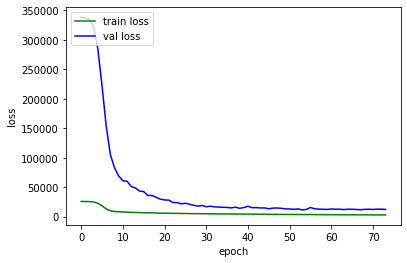

RMSE:  89.43
R-Square:  0.54


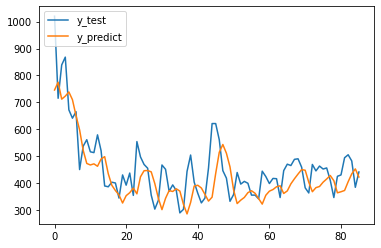

    y_test   y_predict
0     1020  745.785522
1      715  774.679993
2      839  711.694336
3      868  722.972412
4      672  738.584717
..     ...         ...
81     494  372.271790
82     505  404.806580
83     482  433.940521
84     384  452.481689
85     441  422.330261

[86 rows x 2 columns]


In [10]:
# 학습 시각화 함수
def learning_graph(hist):
    fig, loss_ax = plt.subplots()
    loss_ax.plot(hist.history['loss'],'g', label='train loss')
    loss_ax.plot(hist.history['val_loss'],'b', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()
    
learning_graph(hist)

# 실제값, 예측값 그래프
y_predict = model.predict(covid_test_x) ####

# 에러율 - Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_predict, covid_test_y))
print('RMSE: ',rmse.round(2))

r = explained_variance_score(covid_test_y, y_predict)
print('R-Square: ',r.round(2))

fig, loss_ax = plt.subplots()
loss_ax.plot(covid_test_y, label='y_test')
loss_ax.plot(y_predict, label='y_predict')
loss_ax.legend(loc='upper left')
plt.show()

df = pd.DataFrame(covid_test_y)
df.insert(1,'y_predict',y_predict)
df.rename(columns={0:'y_test'}, inplace=True)
print(df)